In [1]:
import sys
print(sys.version)
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest
from src.detectors import LSHiForest
import data_loader as dl
import config

3.13.7 (main, Aug 14 2025, 11:12:11) [Clang 17.0.0 (clang-1700.0.13.3)]


In [5]:
# dataのロード:cic
X_train, y_train, X_test, y_test, y_cat = dl.load_cic_ids()
print(len(X_train))
print(len(X_test))

667626
20000


In [6]:
# 先行研究で実験
num_ensemblers = 100
classifiers = [("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), ("ALSH", LSHiForest('ALSH', num_ensemblers)), ("L2SH", LSHiForest('L2SH', num_ensemblers)), ("L1SH", LSHiForest('L1SH', num_ensemblers)) ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.8161888036699878
	Training time:	 0.25099897384643555
	Testing time:	 0.026973962783813477

ALSH:
	AUC score:	 0.46487993692208446
	Training time:	 41.694648027420044
	Testing time:	 15.188278198242188

L2SH:
	AUC score:	 0.3687821661529639
	Training time:	 48.93664002418518
	Testing time:	 14.493192911148071

L1SH:
	AUC score:	 0.3959028026664755
	Training time:	 50.424527168273926
	Testing time:	 10.43239974975586


In [7]:
# dataのロード:unsw
X_train, y_train, X_test, y_test = dl.load_unsw_nb15()

print(len(X_train))
print(len(X_test))

56000
82332


In [8]:
# 先行研究で実験
num_ensemblers = 100
classifiers = [("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), ("ALSH", LSHiForest('ALSH', num_ensemblers)), ("L2SH", LSHiForest('L2SH', num_ensemblers)), ("L1SH", LSHiForest('L1SH', num_ensemblers)) ]


for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	clf.fit(X_train)
	train_time = time.time()-start_time
	y_pred = clf.decision_function(X_test)
	test_time = time.time()-start_time-train_time
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.4030998059958838
	Training time:	 0.08156108856201172
	Testing time:	 0.14522790908813477

ALSH:
	AUC score:	 0.24682828161480108
	Training time:	 5.316900014877319
	Testing time:	 66.93187308311462

L2SH:
	AUC score:	 0.23248824349364808
	Training time:	 5.634238243103027
	Testing time:	 64.27376914024353

L1SH:
	AUC score:	 0.26146977136847427
	Training time:	 5.40505313873291
	Testing time:	 44.50292205810547



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...

Training and Predicting with L2SH...

Training and Predicting with L1SH...


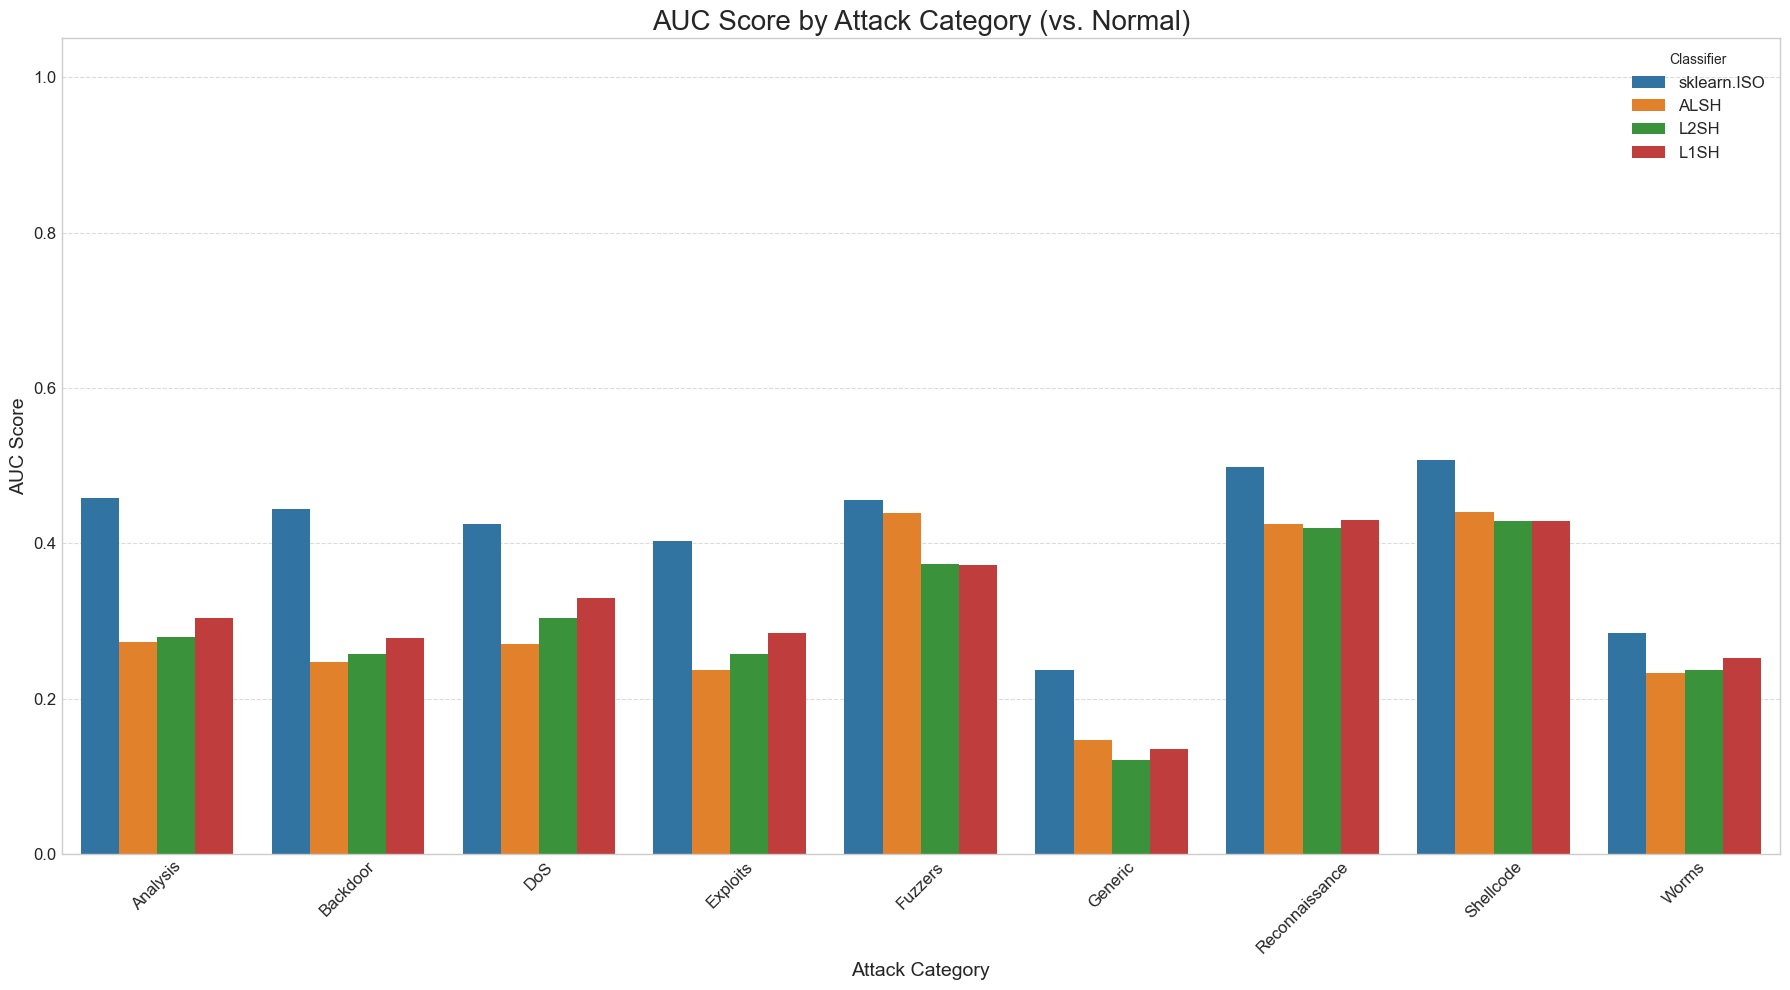

Corrected AUC Scores (Each Attack vs. Normal):
                sklearn.ISO   ALSH   L2SH   L1SH
Analysis             0.4590 0.2728 0.2799 0.3039
Backdoor             0.4447 0.2470 0.2583 0.2787
DoS                  0.4250 0.2703 0.3038 0.3297
Exploits             0.4037 0.2376 0.2574 0.2844
Fuzzers              0.4560 0.4387 0.3734 0.3729
Generic              0.2369 0.1469 0.1218 0.1354
Reconnaissance       0.4985 0.4248 0.4194 0.4301
Shellcode            0.5070 0.4406 0.4286 0.4289
Worms                0.2852 0.2333 0.2368 0.2521


In [10]:
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), 
    ("ALSH", LSHiForest('ALSH', num_ensemblers)), 
    ("L2SH", LSHiForest('L2SH', num_ensemblers)), 
    ("L1SH", LSHiForest('L1SH', num_ensemblers))
]

attack_cat_series = pd.read_csv('../data/unsw_nb15/UNSW_NB15_training-set.csv')['attack_cat']

results_df = pd.DataFrame({
    'attack_cat': attack_cat_series.values,
    'label': y_test.values
}, index=y_test.index)


# --- 3. モデルの学習・予測・結果の保存 ---
if results_df is not None:
    # X_testは数値データのみなので、そのまま予測に使用。
    for clf_name, clf in classifiers:
        print(f"\nTraining and Predicting with {clf_name}...")
        clf.fit(X_train)
        y_pred = clf.decision_function(X_test)
        results_df[f'pred_{clf_name}'] = y_pred

    normal_df = results_df[results_df['label'] == 0]
    attack_df = results_df[results_df['label'] == 1]
    
    corrected_auc_scores = {}
    for clf_name, _ in classifiers:
        scores = {}
        unique_attack_cats = sorted(attack_df['attack_cat'].unique())
        for cat in unique_attack_cats:
            current_attack_df = attack_df[attack_df['attack_cat'] == cat]
            eval_df = pd.concat([normal_df, current_attack_df])
            eval_preds = eval_df[f'pred_{clf_name}']
            eval_labels = eval_df['label']
            auc = roc_auc_score(eval_labels, eval_preds)
            scores[cat] = auc
        corrected_auc_scores[clf_name] = scores

    # グラフ描画と結果表示
    plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
    plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax)
    ax.set_title('AUC Score by Attack Category (vs. Normal)', fontsize=20)
    ax.set_xlabel('Attack Category', fontsize=14)
    ax.set_ylabel('AUC Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Classifier', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("Corrected AUC Scores (Each Attack vs. Normal):")
    pd.options.display.float_format = '{:.4f}'.format
    results_table = pd.DataFrame(corrected_auc_scores)
    print(results_table)

In [2]:
# データの準備:nsl
X_train, y_train, X_test, y_test = dl.load_nsl_kdd()

print(f"Train data size :{len(X_train)}")
print(f"Test data size :{len(X_test)}")

Train data size :67343
Test data size :22544


In [3]:
num_ensemblers = 100
classifiers = [("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)), ("ALSH", LSHiForest('ALSH', num_ensemblers)), ("L2SH", LSHiForest('L2SH', num_ensemblers)), ("L1SH", LSHiForest('L1SH', num_ensemblers)) ]
for i, (clf_name, clf) in enumerate(classifiers):
	
	print("\n"+clf_name+":")
	start_time = time.time()
	
	clf.fit(X_train)
	
	train_time = time.time()-start_time

	y_pred = clf.decision_function(X_test)

	if clf_name == "sklearn.ISO":
		y_pred = -y_pred

	
	test_time = time.time()-start_time-train_time
	
	auc = roc_auc_score(y_test, y_pred)
	
	print("\tAUC score:\t", auc)
	print("\tTraining time:\t", train_time) 
	print("\tTesting time:\t", test_time)


sklearn.ISO:
	AUC score:	 0.9082275269509986
	Training time:	 0.10102987289428711
	Testing time:	 0.04717731475830078

ALSH:
	AUC score:	 0.08041223270221551
	Training time:	 6.509791135787964
	Testing time:	 18.376682996749878

L2SH:
	AUC score:	 0.0850072992760473
	Training time:	 6.2036449909210205
	Testing time:	 18.963170051574707

L1SH:
	AUC score:	 0.08632473095702778
	Training time:	 5.662601947784424
	Testing time:	 13.205711841583252



Training and Predicting with sklearn.ISO...

Training and Predicting with ALSH...

Training and Predicting with L2SH...

Training and Predicting with L1SH...

--- All predictions are stored in results_df ---


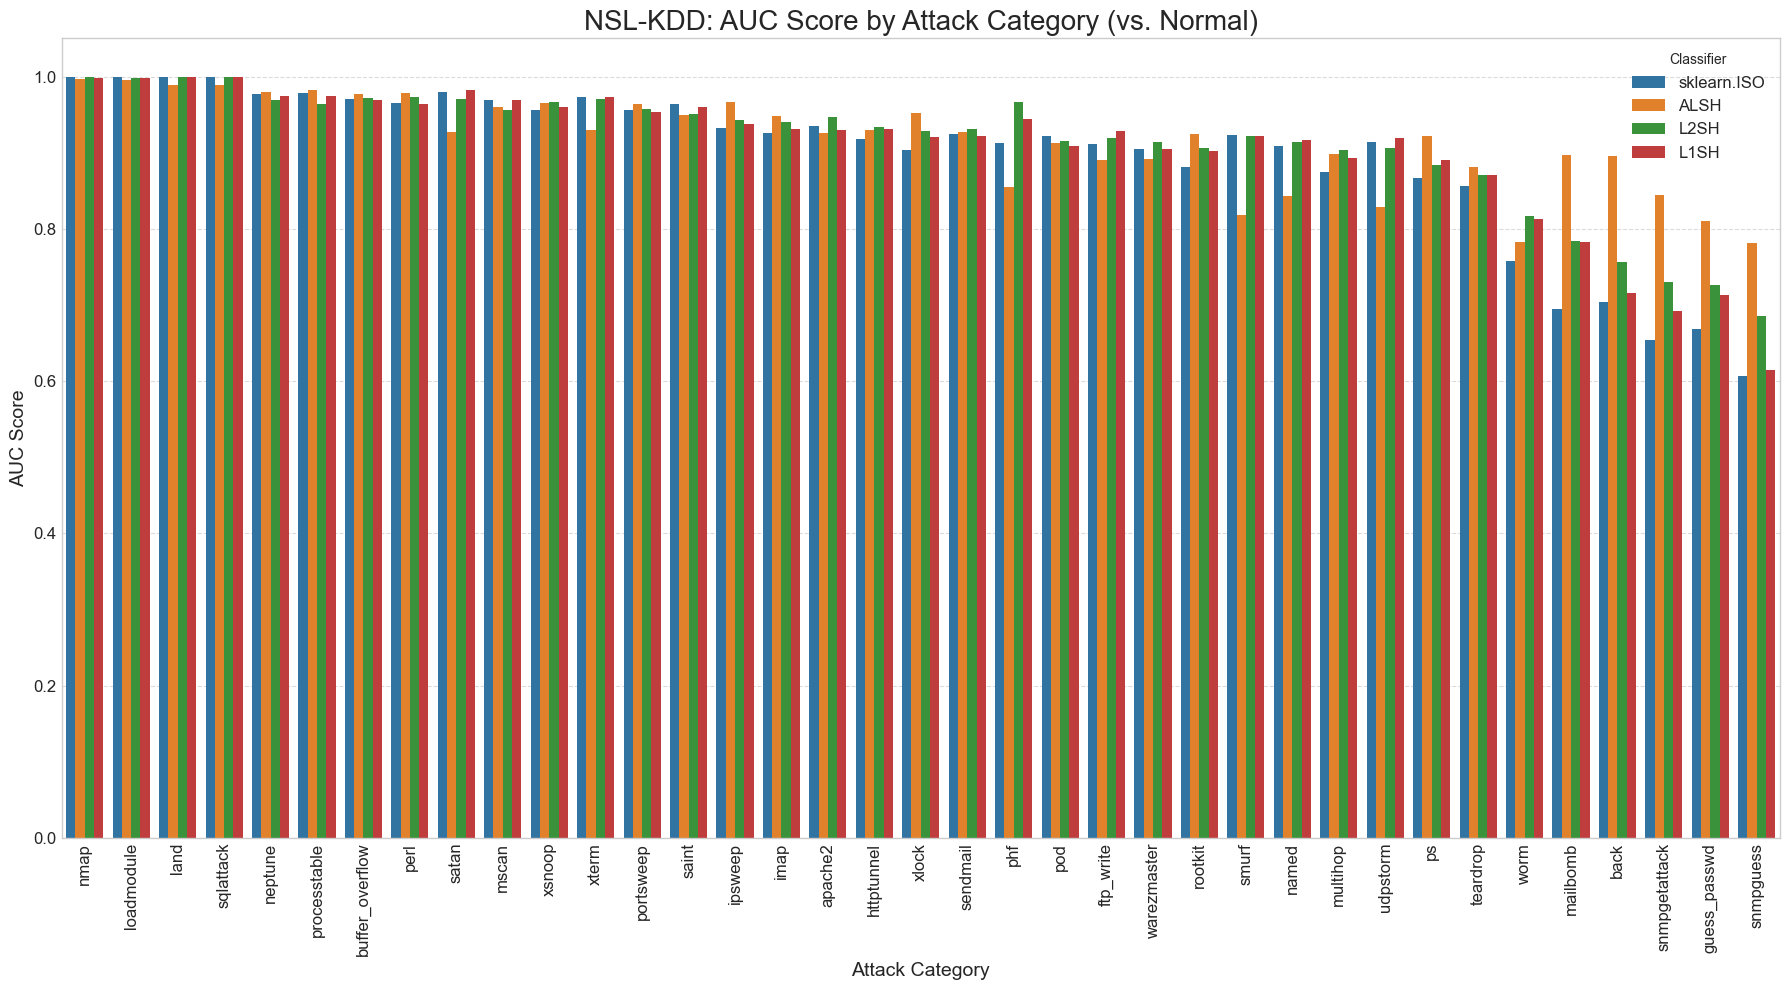


Corrected AUC Scores for NSL-KDD (Each Attack vs. Normal):
Attack Category  nmap  loadmodule  land  sqlattack  neptune  processtable  \
apache2           NaN         NaN   NaN        NaN      NaN           NaN   
back              NaN         NaN   NaN        NaN      NaN           NaN   
buffer_overflow   NaN         NaN   NaN        NaN      NaN           NaN   
ftp_write         NaN         NaN   NaN        NaN      NaN           NaN   
guess_passwd      NaN         NaN   NaN        NaN      NaN           NaN   
httptunnel        NaN         NaN   NaN        NaN      NaN           NaN   
imap              NaN         NaN   NaN        NaN      NaN           NaN   
ipsweep           NaN         NaN   NaN        NaN      NaN           NaN   
land              NaN         NaN   NaN        NaN      NaN           NaN   
loadmodule        NaN         NaN   NaN        NaN      NaN           NaN   
mailbomb          NaN         NaN   NaN        NaN      NaN           NaN   
mscan           

In [7]:
num_ensemblers = 100
classifiers = [
    ("sklearn.ISO", IsolationForest(n_estimators=num_ensemblers)),
    ("ALSH", LSHiForest('ALSH', num_ensemblers)),
    ("L2SH", LSHiForest('L2SH', num_ensemblers)),
    ("L1SH", LSHiForest('L1SH', num_ensemblers))
]

# --- 2.【重要】NSL-KDDの攻撃カテゴリ名を取得し、予測結果を格納するDataFrameを準備 ---
results_df_created = False
try:
    test_df_for_cat = pd.read_csv('../data/nsl_kdd/KDDTest+.txt', header=None, names=config.columns_nsl)
    # attack列の値を空白除去
    attack_cat_series = test_df_for_cat['class'].str.strip()
    results_df_created = True
except FileNotFoundError:
    print("Error: '../data/nsl_kdd/KDDTest+.txt' が見つかりません。ファイルパスを確認してください。")


if results_df_created:
    # y_test（0/1ラベル）とattack_cat（攻撃カテゴリ名）でDataFrameを作成
    results_df = pd.DataFrame({
        'attack_cat': attack_cat_series.values,
        'label': y_test.values
    }, index=y_test.index)

    # --- 3. モデルの学習・予測・結果の保存 ---
    for clf_name, clf in classifiers:
        print(f"\nTraining and Predicting with {clf_name}...")
        clf.fit(X_train)
        y_pred = clf.decision_function(X_test)
        results_df[f'pred_{clf_name}'] = y_pred
    print("\n--- All predictions are stored in results_df ---")

    # --- 4. カテゴリ別AUCの計算 ---
    normal_df = results_df[results_df['label'] == 0]
    attack_df = results_df[results_df['label'] == 1]

    corrected_auc_scores = {}
    for clf_name, _ in classifiers:
        scores = {}
        unique_attack_cats = sorted([cat for cat in attack_df['attack_cat'].unique() if cat != 'normal'])
        for cat in unique_attack_cats:
            current_attack_df = attack_df[attack_df['attack_cat'] == cat]
            eval_df = pd.concat([normal_df, current_attack_df])
            eval_preds = eval_df[f'pred_{clf_name}']
            eval_labels = eval_df['label']
            
            if len(eval_labels.unique()) > 1:
                auc = roc_auc_score(eval_labels, -eval_preds)
                scores[cat] = auc
            else:
                scores[cat] = None
        corrected_auc_scores[clf_name] = scores

    # --- 5. グラフ描画と結果表示 ---
    plot_df = pd.DataFrame(corrected_auc_scores).T.rename_axis('Classifier').reset_index()
    plot_df_melted = plot_df.melt(id_vars='Classifier', var_name='Attack Category', value_name='AUC Score').dropna()

    # カテゴリごとの平均AUCを算出し、降順でカテゴリの順序を決定
    category_order = plot_df_melted.groupby('Attack Category')['AUC Score'].mean().sort_values(ascending=False).index

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(18, 10))
    # order引数に決定した順序を指定
    sns.barplot(data=plot_df_melted, x='Attack Category', y='AUC Score', hue='Classifier', ax=ax, order=category_order)
    
    ax.set_title('NSL-KDD: AUC Score by Attack Category (vs. Normal)', fontsize=20)
    ax.set_xlabel('Attack Category', fontsize=14)
    ax.set_ylabel('AUC Score', fontsize=14)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.legend(title='Classifier', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('nsl_kdd_auc_by_category.png')
    plt.show()

    print("\nCorrected AUC Scores for NSL-KDD (Each Attack vs. Normal):")
    pd.options.display.float_format = '{:.4f}'.format
    # テーブルもグラフの順序に合わせて表示
    results_table = pd.DataFrame(corrected_auc_scores).reindex(category_order, axis=1) 
    print(results_table)